In [2]:
import sncosmo
from scipy.constants import speed_of_light, Planck, Boltzmann
from scipy.interpolate import InterpolatedUnivariateSpline as Spline1d

In [36]:
print Planck*speed_of_light/Boltzmann*1e10/1e8
print 2*Planck*speed_of_light**2*1e50

1.43877735383
1.19104295262e+34


In [37]:
def blackbody(wl, T=2e4):
    # wl in Ångströms
    # T in Kelvin
    # output is not normalized because sncosmo amplitude will be scaled to some arbitrary value
    return 1.19104295262e+34 * wl**-5 / (np.exp(1.43877735383e+8 / (wl*T)) - 1)

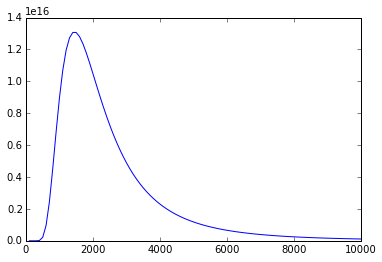

In [38]:
wl = np.linspace(100, 10000, 100)
plt.plot(wl, blackbody(wl))

In [150]:
from sncosmo import Source

class BlackBodySource(Source):
    """A simple spectral source for a transient with a 
    black-body spectrum of constant temperature
    The spectral flux density of this model is given by
    .. math::
       F(t, \lambda) = A \\times LC(t / s) \\times B(\lambda, T)
    where _A_ is the amplitude, _s_ is the "stretch" and 
    _T_ is the black-body temperature; LC is a dimensionless 
    lightcurve that defines the time evolution of the flux 
    while B is the black-body spectrum.
    Parameters
    ----------
    phase : `~numpy.ndarray`
        Phases in days.
    flux : `~numpy.ndarray`
        Model spectral flux density in arbitrary units.
        Must have shape `(num_phases)`.
    """

    _param_names = ['amplitude', 's', 'T']
    param_names_latex = ['A', 's', 'T']

    def __init__(self, phase, flux, name=None, version=None):
        self.name = name
        self.version = version
        self._phase = phase
        self._parameters = np.array([1., 1., 2e4])
        self._model_lc = Spline1d(phase, flux, k=2)

    def minwave(self):  
        return 1e-100

    def maxwave(self):  
        return 1e100
    
    def minphase(self):
        return self._parameters[1] * self._phase[0]

    def maxphase(self):
        return self._parameters[1] * self._phase[-1]

    def _flux(self, phase, wave):
        return np.outer(self._parameters[0] *
                        self._model_lc(phase / self._parameters[1]),
                        blackbody(wave, self._parameters[2]))

In [151]:
template = np.genfromtxt('14aon_smoothed_lc.dat')

In [155]:
source = BlackBodySource(template[:,0], template[:,1])
model = sncosmo.Model(source=source)
model.set(z=0.01)
model.set_source_peakabsmag(-18,'sdssg','ab')

In [156]:
model.bandmag('sdssr', 'ab', [0,10])

array([ 15.52482165,  15.54702543])

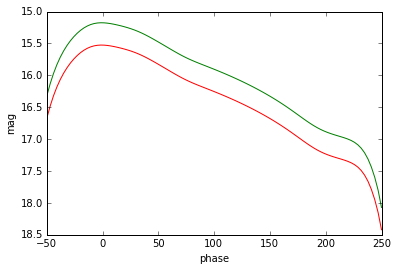

In [161]:
p = np.linspace(-50,250,100)
plt.plot(p, model.bandmag('sdssg', 'ab', p), 'g-')
plt.plot(p, model.bandmag('sdssr', 'ab', p), 'r-')
plt.gca().invert_yaxis()
plt.xlabel('phase')
plt.ylabel('mag')

In [173]:
# g-r colors for different temperatures (supposedto be < -0.5?)
for T in [5e3, 1e4, 2e4, 5e4, 1e5, 5e5]:
    model.set(T=T)
    gr = model.bandmag('sdssg', 'ab', 0) - model.bandmag('sdssr', 'ab', 0)
    print 'T = {:>6.0f} K: g-r = {:>5.2f}'.format(T, gr)
model.set(T=2e4)

T =   5000 K: g-r =  0.72
T =  10000 K: g-r = -0.02
T =  20000 K: g-r = -0.35
T =  50000 K: g-r = -0.52
T = 100000 K: g-r = -0.56
T = 500000 K: g-r = -0.60
